### Loading packages

In [1]:
#Loading packages
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/global/home/hpc5434/multimodal/Spec/TabSS')

from TabSS import TabShaSpec, TabShaSpecAttention, TabShaSpecAttentionGlobal
from TabSS import TabShaSpecWrapper  # <--- wrapper

print("packages A loaded")
### defines function for finding continuous and categorical variables
def find_binary_columns(df):
    binary_columns = []
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        if len(unique_values) == 2:
            binary_columns.append(column)
    return binary_columns

def find_continuous_columns(df):
    continuous_columns = []
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        if len(unique_values) > 2:
            continuous_columns.append(column)
    return continuous_columns

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class NaNIgnoringScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        """
        Compute mean and std while ignoring NaN values.
        """
        self.mean_ = np.nanmean(X, axis=0)
        self.scale_ = np.nanstd(X, axis=0)
        return self

    def transform(self, X):
        """
        Scale data using the computed mean and std, ignoring NaNs.
        """
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X, y=None):
        """
        Compute mean and std, and scale the data.
        """
        return self.fit(X, y).transform(X)
    



packages A loaded


### Making synthetic dataset

In [2]:
### SYNTHETIC DATSET ###
np.random.seed(6)

n_samples = 500

# View 1: Polygenic Risk Score (PRS)
PRS = np.random.normal(0, 1, n_samples)

# View 2: Environmental exposures (binary and continuous)
E1 = np.random.binomial(n=1, p=0.2, size=n_samples)  # e.g., mom smoking
E2 = np.random.binomial(n=1, p=0.5, size=n_samples)  # e.g., any pets
E3 = np.random.normal(0, 1, n_samples)               # e.g., air pollution index

# View 3: Prenatal diet (correlated nutrients)
D1 = np.random.normal(0, 1, n_samples)               # e.g., dietary iron
D2 = 0.6 * D1 + np.random.normal(0, 0.5, n_samples)  # e.g., calcium

# View 4: Milk metabolomics (with 50% missing)
M1 = np.random.normal(0, 1, n_samples)
M2 = 0.5 * M1 + np.random.normal(0, 0.5, n_samples)



In [3]:
'''
#DATASET 1
y = (
    0.2 * PRS +
    0.1 * E1 +        
    0.05 * E2 +
    0.08 * E3 +
    0.1 * D1 +
    0.03 * D2 +
    0.12 * M1 +
    0.05 * M2     
    #+ np.random.normal(0, 0.5, n_samples)  # noise
)

#DATSET 2 (with interactions/more complexity)
y = (
    #0.1 * PRS +
    0.1 * E1 +        
    0.05 * E2 +
    0.08 * E3 +
    0.03 * D2 +
    0.12 * M1 +
    0.05 * M2     
    #+ np.random.normal(0, 0.5, n_samples)  # noise

    + 0.5 * (M1 > 1.5)
    + 0.3 * PRS * D1
)
'''
#DATSET 3 (increase weights from dataset 2)
y = (
    #0.1 * PRS +
    1 * E1 +        
    0.5 * E2 +
    0.8 * E3 +
    0.3 * D2 +
    0.2 * M1 +
    0.5 * M2     
    #+ np.random.normal(0, 0.5, n_samples)  # noise

    + 1.5 * (M1 > 1.5)
    + 1.3 * PRS * D1
)




In [4]:


# Clip target to simulate z-score range
y = np.clip(y, -3, 3)

# Assemble into a DataFrame
synthetic_df = pd.DataFrame({
    'PRS': PRS,
    'E1': E1,
    'E2': E2,
    'E3': E3,
    'D1': D1,
    'D2': D2,
    'M1': M1,
    'M2': M2,
    'y': y
})

# Preview
print(synthetic_df.head())

        PRS  E1  E2        E3        D1        D2        M1        M2  \
0 -0.311784   0   0 -0.197577  2.762230  1.393052 -0.042963 -0.044401   
1  0.729004   0   0  0.010809 -0.700249  0.193110 -1.360888 -0.508929   
2  0.217821   0   0  1.126930  0.372454  0.672996 -0.774406 -0.428322   
3 -0.899092   0   0  0.040286  1.287372  0.921094  0.121715  0.418134   
4 -2.486781   1   0  0.672958 -1.643655 -1.265274  0.804036 -0.001472   

          y  
0 -0.890522  
1 -1.123691  
2  0.839867  
3 -0.962738  
4  3.000000  


In [73]:
### ADDING NA VALUES

import numpy as np

# Randomly choose 50% of the rows
mask = np.random.rand(len(synthetic_df)) < 0.8

# Set M1 and M2 to NaN in those rows
synthetic_df.loc[mask, ['M1', 'M2']] = np.nan


In [9]:
import json

feature_categories = {
    "PRS": ["PRS"],
    "Exposure": ["E1", "E2", "E3"],
    "Diet": ["D1", "D2"],
    "Milk": ["M1", "M2"]
}

with open("synthetic_feature_categories.json", "w") as f:
    json.dump(feature_categories, f, indent=2)

In [5]:
X = synthetic_df.dropna().drop(columns='y')
y = synthetic_df.dropna()['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Linear and random forest model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

import pickle

# Clean and split
X = synthetic_df.dropna().drop(columns='y')
y = synthetic_df.dropna()['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression ---
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
y_pred_linreg = linreg_model.predict(X_test)

# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- XGBoost ---
hgb_model = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, random_state=42)
hgb_model.fit(X_train, y_train)
y_pred_hgb = hgb_model.predict(X_test)


# --- Evaluation ---
print("Linear Regression:")
print("R² Score:", r2_score(y_test, y_pred_linreg))
print("MSE:", mean_squared_error(y_test, y_pred_linreg))

print("\nRandom Forest:")
print("R² Score:", r2_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))

print("\HGBoost:")
print("R² Score:", r2_score(y_test, y_pred_hgb))
print("MSE:", mean_squared_error(y_test, y_pred_hgb))
''''''
# --- Save models ---
suffix = "large_weight"
with open(f'random_forest_model_{suffix}.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open(f'linear_model_{suffix}.pkl', 'wb') as f:
    pickle.dump(linreg_model, f)
with open(f'hgboost_model_{suffix}.pkl', 'wb') as f:
    pickle.dump(hgb_model, f)


Linear Regression:
R² Score: 0.398917021184339
MSE: 1.3764451232091444

Random Forest:
R² Score: 0.6106620357073185
MSE: 0.8915613336560425
\HGBoost:
R² Score: 0.8062458187996523
MSE: 0.44368582577412835


In [9]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# X_train_df: your training features (DataFrame or array)
# y: your target variable (e.g., lung function)
X = synthetic_df.dropna().drop(columns='y')
y = synthetic_df.dropna()['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train SVM with scaling
svm_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1)
)

svm_model.fit(X_train, y_train)

# Optional evaluation
y_pred = svm_model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R²: 0.8480101448872659
MSE: 0.3480479438286443


In [73]:
y_pred_rf = rf_model.predict(X_test)

In [89]:
%timeit rf_model.predict(X_train.iloc[:1])


3.82 ms ± 88.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [91]:
%timeit linreg_model.predict(X_train.iloc[:1])


858 µs ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [68]:
X_train.to_csv(f"synthetic_train_{suffix}.csv")
X_test.to_csv(f"synthetic_test_{suffix}.csv")

In [14]:
coef = linreg_model.coef_        # slope(s)
intercept = linreg_model.intercept_  # y-intercept

# Print equation
terms = [f"{coef[i]:.5f} * x{i+1}" for i in range(len(coef))]
equation = " + ".join(terms)
print(f"y = {equation} + {intercept:.2f}")


y = 0.17095 * x1 + 0.07529 * x2 + 0.07370 * x3 + 0.07939 * x4 + 0.10246 * x5 + 0.03658 * x6 + 0.20582 * x7 + 0.01388 * x8 + 0.02


### TabShaSpec

In [9]:
suffix = "complex"

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, test_size=0.2, random_state=42)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Multimodal model (adapted for single-modal use)


# Model parameters
input_dims = [1, 3, 2, 2]

hidden_dim_pre = [2, 8, 4, 4]
shared_dim = 4
hidden_dim_shared = 4
r_dim = 4



hidden_dims = [2, 8, 4, 4]
latent_dim = [4, 4, 4, 4]
       
output_dim = 1    

# Define input dimensions for each view
#input_dims = [22]  # Example: 3 views with 50, 30, and 20 features each



scaler = NaNIgnoringScaler()
binary_columns = find_binary_columns(pd.DataFrame(X_train))


# Initialize the model
print("Using TabShaSpec1")
model = TabShaSpecAttentionGlobal(input_dims, shared_dim, hidden_dim_pre, hidden_dim_shared, hidden_dims, r_dim, latent_dim, output_dim)
wrapper = TabShaSpecWrapper(model, input_dims, binary_columns)
wrapper = wrapper.to(device)  # Use 'cuda' if a GPU is available
criterion = nn.MSELoss()
num_epochs = 500

#2) loss and optimizer
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(wrapper.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


#On X and y tensor
# List of indices to exclude
# Pre-scale continuous columns only
scaler = NaNIgnoringScaler()
mask = np.array([i for i in range(X_train.shape[1]) if i not in binary_columns])
X_train[:, mask] = scaler.fit_transform(X_train[:, mask], y_train)
X_val[:, mask] = scaler.transform(X_val[:, mask])


# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y if necessary

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Reshape y if necessary


X_train_combined = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_combined = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)


# Training loop
for epoch in range(num_epochs):
    wrapper.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = wrapper(X_train_combined)


    # Compute loss
    loss = criterion(predictions, y_train)
    

    # Backward pass and optimizer step
    loss.backward()
    optimizer.step()
    #scheduler.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Learning Rate: {current_lr:.6f}')


        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = wrapper(X_val_combined)
            val_loss = criterion(val_predictions, y_val).item()
            val_r2 = r2_score(y_val.cpu().numpy(), val_predictions.cpu().numpy())
            print(f'Validation Loss: {val_loss:.4f}, R²: {val_r2:.4f}')


import os
import pickle
with open(f"wrapper_{suffix}.pkl", "wb") as f:
    pickle.dump(wrapper, f)

model_dir = os.path.expanduser("~/MAP-CF/synthetic")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"synthetic_{suffix}.pth")
torch.save(wrapper, model_path)
print(f"Model saved successfully at {model_path}")


###### load the model
import pickle

# Load the model
# # Instantiate the model architecture
model_path = os.path.expanduser(f"~/MAP-CF/synthetic/synthetic_{suffix}.pth")
criterion = nn.MSELoss()

# Load the state dictionary
#model.load_state_dict(torch.load(model_path, map_location=device))
print("Model loaded successfully")



wrapper = torch.load(model_path, map_location=torch.device('cpu'))  # unpickles the entire wrapper object
wrapper.eval()
with torch.no_grad():
    val_predictions = wrapper(X_val_combined)
    val_loss = criterion(val_predictions, y_val).item()
    val_r2 = r2_score(y_val.cpu().numpy(), val_predictions.cpu().numpy())
    print(f" Validation Loss: {val_loss:.4f}, R²: {val_r2:.4f}")



Using TabShaSpec1


/tmp/ipykernel_3908224/1652032623.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_combined = torch.tensor(X_train, dtype=torch.float32).to(device)
/tmp/ipykernel_3908224/1652032623.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
/tmp/ipykernel_3908224/1652032623.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_combined = torch.tensor(X_val, dtype=torch.float32).to(device)
/tmp/ipykernel_3908224/1652032623.py:68: UserWarning: To copy con

Epoch 10/500, Loss: 0.1369, Learning Rate: 0.100000
Validation Loss: 0.1661, R²: 0.0405
Epoch 20/500, Loss: 0.1301, Learning Rate: 0.100000
Validation Loss: 0.1619, R²: 0.0644
Epoch 30/500, Loss: 0.1285, Learning Rate: 0.100000
Validation Loss: 0.1612, R²: 0.0684
Epoch 40/500, Loss: 0.1265, Learning Rate: 0.100000
Validation Loss: 0.1604, R²: 0.0730
Epoch 50/500, Loss: 0.1287, Learning Rate: 0.100000
Validation Loss: 0.1596, R²: 0.0779
Epoch 60/500, Loss: 0.1290, Learning Rate: 0.100000
Validation Loss: 0.1585, R²: 0.0840
Epoch 70/500, Loss: 0.1294, Learning Rate: 0.100000
Validation Loss: 0.1584, R²: 0.0847
Epoch 80/500, Loss: 0.1276, Learning Rate: 0.100000
Validation Loss: 0.1567, R²: 0.0945
Epoch 90/500, Loss: 0.1298, Learning Rate: 0.100000
Validation Loss: 0.1559, R²: 0.0992
Epoch 100/500, Loss: 0.1254, Learning Rate: 0.100000
Validation Loss: 0.1548, R²: 0.1057
Epoch 110/500, Loss: 0.1235, Learning Rate: 0.100000
Validation Loss: 0.1548, R²: 0.1058
Epoch 120/500, Loss: 0.1269, L

/tmp/ipykernel_3908224/1652032623.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wrapper = torch.load(model_path, map_location=torch.device('cpu'))  # unpickles the e

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import os

torch.manual_seed(6)

# 1. Train/val split
X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

# 2. Preprocess (standard scale)
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)

# 3. Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# 4. Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_val = X_train.to(device), X_val.to(device)
y_train, y_val = y_train.to(device), y_val.to(device)

# 5. Simple MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

mlp_model = SimpleMLP(X_train.shape[1]).to(device)

# 6. Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-3)
num_epochs = 1000

# 7. Training loop
for epoch in range(num_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    predictions = mlp_model(X_train)
    loss = criterion(predictions, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        mlp_model.eval()
        with torch.no_grad():
            val_preds = mlp_model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            val_r2 = r2_score(y_val.cpu().numpy(), val_preds.cpu().numpy())
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val R²: {val_r2:.4f}")

with open(f"mlp_model_{suffix}.pkl", "wb") as f:
    pickle.dump(mlp_model, f)

model_dir = os.path.expanduser("~/MAP-CF/synthetic")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"mlp_model_{suffix}.pth")
torch.save(mlp_model.state_dict(), model_path)
print(f"Model saved successfully at {model_path}")



Epoch 10, Loss: 1.9485, Val Loss: 2.2787, Val R²: 0.0049
Epoch 20, Loss: 1.6766, Val Loss: 2.0473, Val R²: 0.1060
Epoch 30, Loss: 1.4290, Val Loss: 1.8274, Val R²: 0.2020
Epoch 40, Loss: 1.1900, Val Loss: 1.5874, Val R²: 0.3068
Epoch 50, Loss: 0.9546, Val Loss: 1.3330, Val R²: 0.4179
Epoch 60, Loss: 0.7482, Val Loss: 1.1046, Val R²: 0.5176
Epoch 70, Loss: 0.5721, Val Loss: 0.9072, Val R²: 0.6038
Epoch 80, Loss: 0.4172, Val Loss: 0.7295, Val R²: 0.6814
Epoch 90, Loss: 0.2921, Val Loss: 0.5784, Val R²: 0.7474
Epoch 100, Loss: 0.2067, Val Loss: 0.4591, Val R²: 0.7995
Epoch 110, Loss: 0.1552, Val Loss: 0.3762, Val R²: 0.8357
Epoch 120, Loss: 0.1253, Val Loss: 0.3204, Val R²: 0.8601
Epoch 130, Loss: 0.1067, Val Loss: 0.2825, Val R²: 0.8766
Epoch 140, Loss: 0.0949, Val Loss: 0.2580, Val R²: 0.8874
Epoch 150, Loss: 0.0865, Val Loss: 0.2418, Val R²: 0.8944
Epoch 160, Loss: 0.0797, Val Loss: 0.2299, Val R²: 0.8996
Epoch 170, Loss: 0.0743, Val Loss: 0.2211, Val R²: 0.9035
Epoch 180, Loss: 0.0698

NameError: name 'suffix' is not defined

In [41]:
print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val R²: {val_r2:.4f}")

Epoch 1000, Loss: 0.0000, Val Loss: 0.0063, Val R²: 0.9637


### Counterfactuals

In [12]:
sys.path.append('/global/home/hpc5434/MAP-CF')
import cf_search.map as mapcf


### SHAP

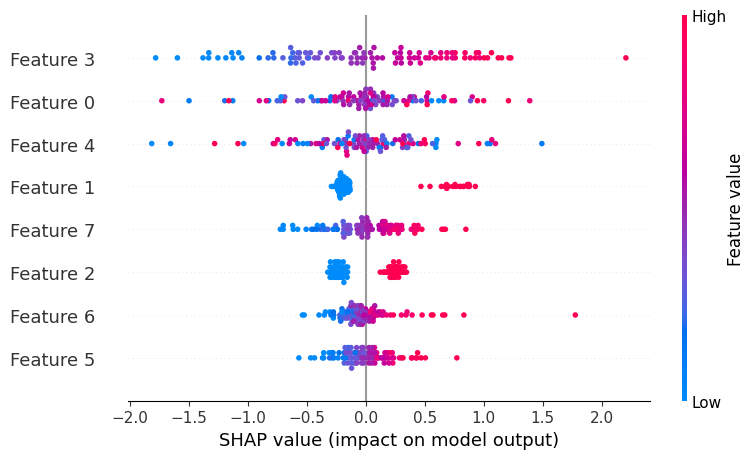

In [9]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Load your trained models (already trained)
# Assume you have:
# - linreg_model
# - rf_model
# - X_train_df (your feature matrix for training)
# - X_test_df (your test feature matrix)


# --- Linear Model SHAP ---
model = mlp_model
# Use TreeExplainer for random forest
#explainer = shap.TreeExplainer(model)
#explainer = shap.KernelExplainer(lambda x: model.predict(x), X_train)
explainer = shap.GradientExplainer(model, X_val)


# Calculate SHAP values
shap_values = explainer.shap_values(X_val)

# Visualize SHAP summary plot for random forest
shap.summary_plot(shap_values, X_val)


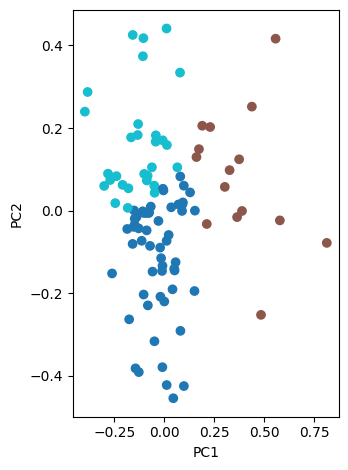

In [21]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Step 1: Convert SHAP values to a 2D array ---

# For random forest
shap_matrix = shap_values  # already a (n_samples, n_features) array from TreeExplainer

# --- Step 2: Cluster the SHAP vectors ---

n_clusters = 3  # you can choose 2, 3, 4 etc.

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(shap_matrix)

# --- Step 3: Visualize the clustering (optional simple plot) ---

# Use PCA or UMAP to reduce SHAP vectors to 2D for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_matrix)

# Plot Random Forest SHAP clusters
plt.subplot(1, 2, 2)
plt.scatter(shap_pca[:, 0], shap_pca[:, 1], c=clusters, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


#### SHAP clustering

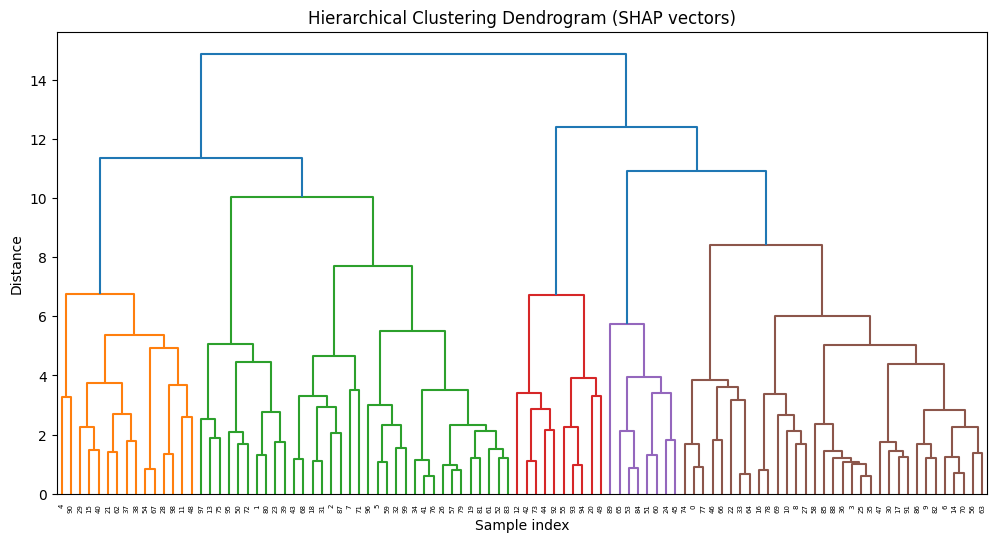

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

# Assume you already have:
# shap_matrix = SHAP values, shape (n_samples, n_features)
# From your earlier steps:
shap_matrix = shap_values   # (or shap_values_rf for random forest)

# If your shap_matrix is not standardized, standardize it (optional but often improves clustering)
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# --- Step 1: Perform hierarchical clustering ---
# 'ward' linkage + Euclidean distance
Z = linkage(shap_matrix_scaled, method='ward', metric='euclidean')

# --- Step 2: Plot dendrogram to visualize ---
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (SHAP vectors)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# --- Step 3: Cut dendrogram into clusters ---
n_clusters = 3
height = 5
#cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
cluster_labels = fcluster(Z, t=height, criterion='distance')

# Now:
# cluster_labels is a (n_samples,) array assigning each sample to a cluster 1, 2, 3


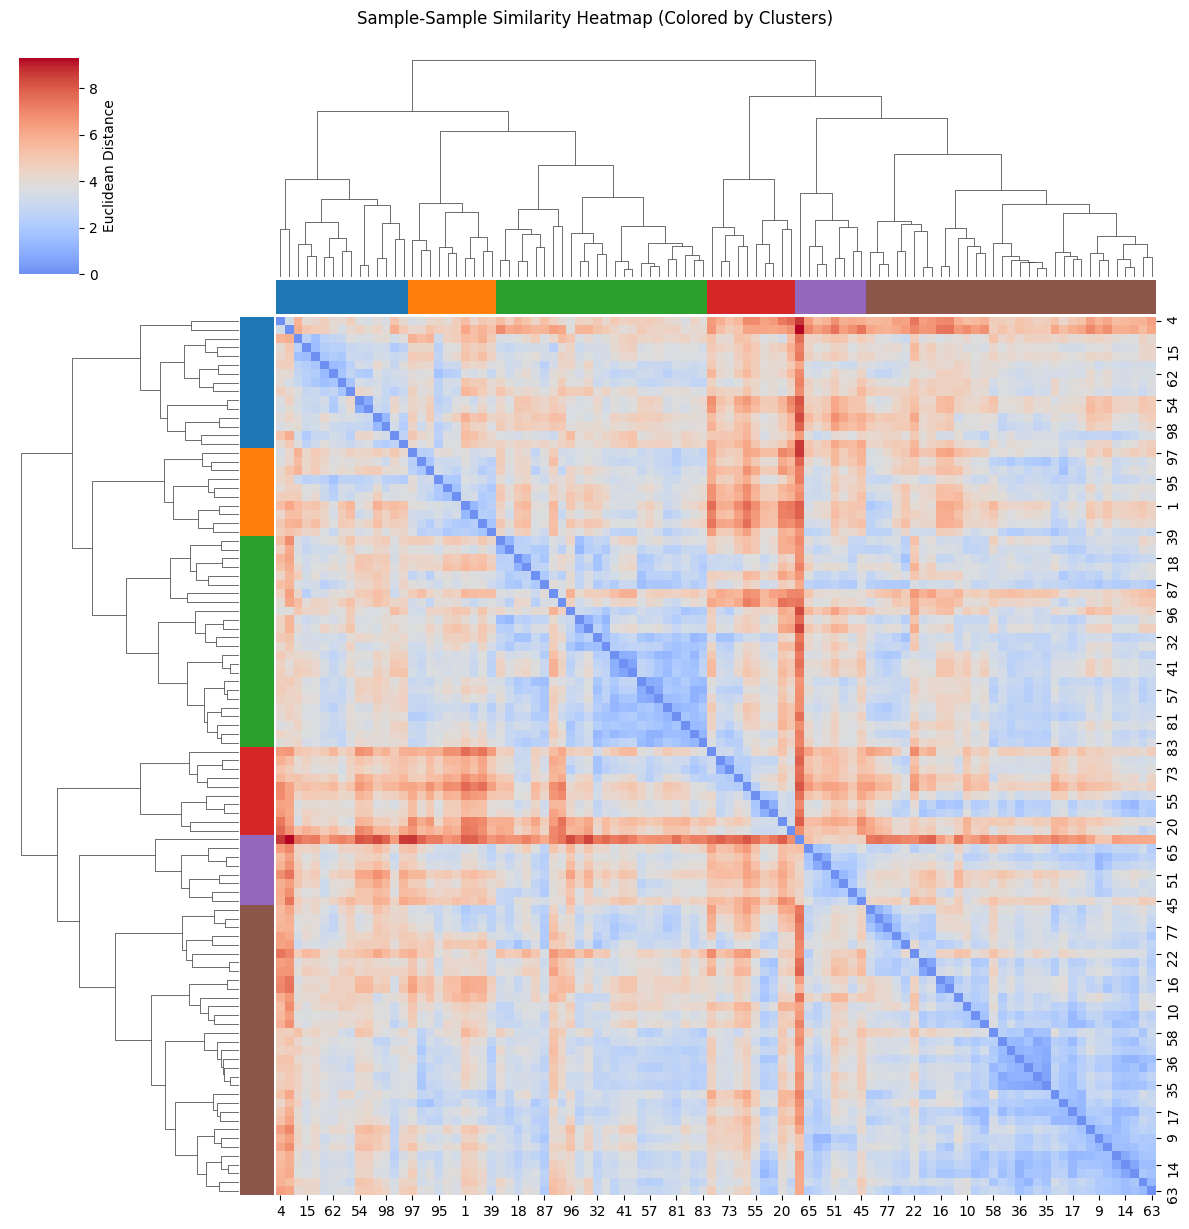

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.preprocessing import StandardScaler

# --- Assume you have your shap_matrix (n_samples, n_features) ---

# Step 1: Standardize SHAP values
scaler = StandardScaler()
shap_matrix_scaled = scaler.fit_transform(shap_matrix)

# Step 2: Compute pairwise distances
pairwise_distances = pdist(shap_matrix_scaled, metric='euclidean')
distance_matrix = squareform(pairwise_distances)

# Step 3: Hierarchical clustering
Z = linkage(pairwise_distances, method='ward')

# Step 4: Cut tree into clusters
n_clusters = 3
height = 10
#cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
cluster_labels = fcluster(Z, t=height, criterion='distance')
n_clusters = len(cluster_labels)
# Step 5: Assign colors to cluster labels
palette = sns.color_palette("tab10", n_clusters)
cluster_color_mapping = dict(zip(np.unique(cluster_labels), palette))
row_colors = pd.Series(cluster_labels).map(cluster_color_mapping).to_numpy()

# Step 6: Create clustermap
sns.clustermap(distance_matrix,
                   row_linkage=Z,
                   col_linkage=Z,
                   row_colors=row_colors,
                   col_colors=row_colors,
                   cmap='coolwarm',  # <- makes sure the HEATMAP (distance matrix) is coolwarm!
                   center=np.median(distance_matrix),  # Centering at median distance
                   figsize=(12, 12),
                   cbar_kws={"label": "Euclidean Distance"})

plt.suptitle('Sample-Sample Similarity Heatmap (Colored by Clusters)', y=1.02)
plt.show()


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


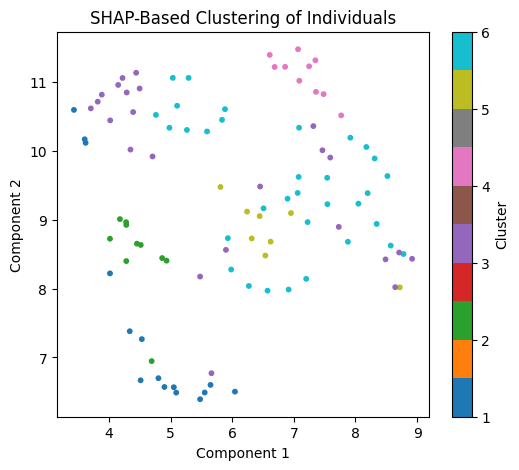

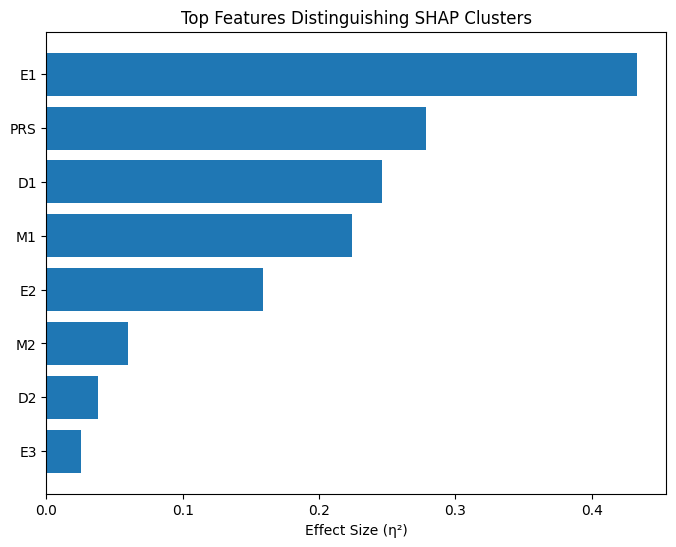

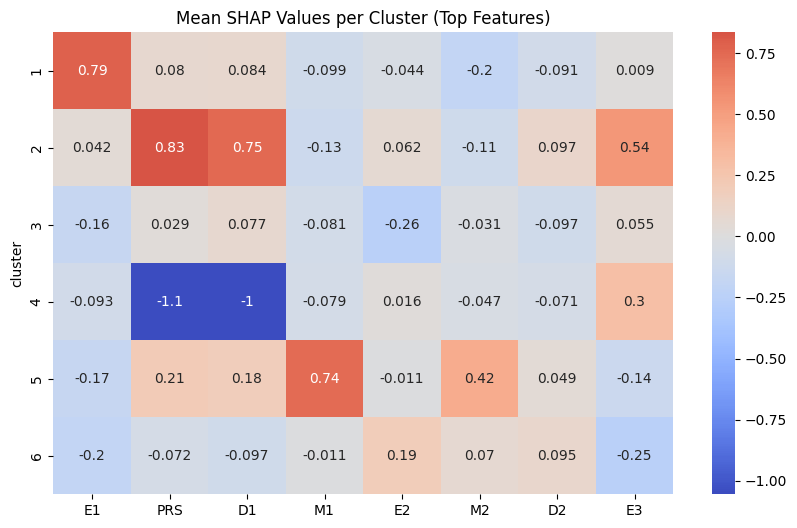

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.feature_selection import f_classif

# Assume:
# - shap_matrix (n_samples, n_features)
# - cluster_labels (n_samples,)

# --- Step 2: Project SHAP vectors into 2D for visualization ---

# Option 1: PCA
pca = PCA(n_components=2)
shap_pca = pca.fit_transform(shap_matrix)

# Option 2 (better): UMAP
try:
    from umap import UMAP
    umap_model = UMAP(random_state=42)
    shap_umap = umap_model.fit_transform(shap_matrix)
except ImportError:
    shap_umap = shap_pca  # fallback to PCA if UMAP not available

# --- Step 3: Scatter plot colored by cluster ---

plt.figure(figsize=(6, 5))
plt.scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title('SHAP-Based Clustering of Individuals')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label="Cluster")
plt.show()

# --- Step 4: One-way ANOVA across clusters to find η² for each feature ---

# f_classif returns (F-values, p-values)
F_values, p_values = f_classif(shap_matrix, cluster_labels)

# η² (eta squared) = between-group variability / total variability
eta_squared = F_values / (F_values + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# --- Step 5: Rank features by η² and plot ---

# Sort by eta_squared descending
feature_names = X_test.columns.tolist()  # or however you have feature names
sorted_idx = np.argsort(-eta_squared)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2 = eta_squared[sorted_idx][:10]

# Barplot of top features
plt.figure(figsize=(8, 6))
plt.barh(top_features[::-1], top_eta2[::-1])
plt.xlabel('Effect Size (η²)')
plt.title('Top Features Distinguishing SHAP Clusters')
plt.show()

# --- Step 6: Average SHAP profiles per cluster ---

cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels

# Group by cluster
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

# Heatmap of average SHAP values
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(mean_shap_by_cluster.loc[:, top_features], annot=True, cmap='coolwarm', center=0)
plt.title('Mean SHAP Values per Cluster (Top Features)')
plt.show()


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


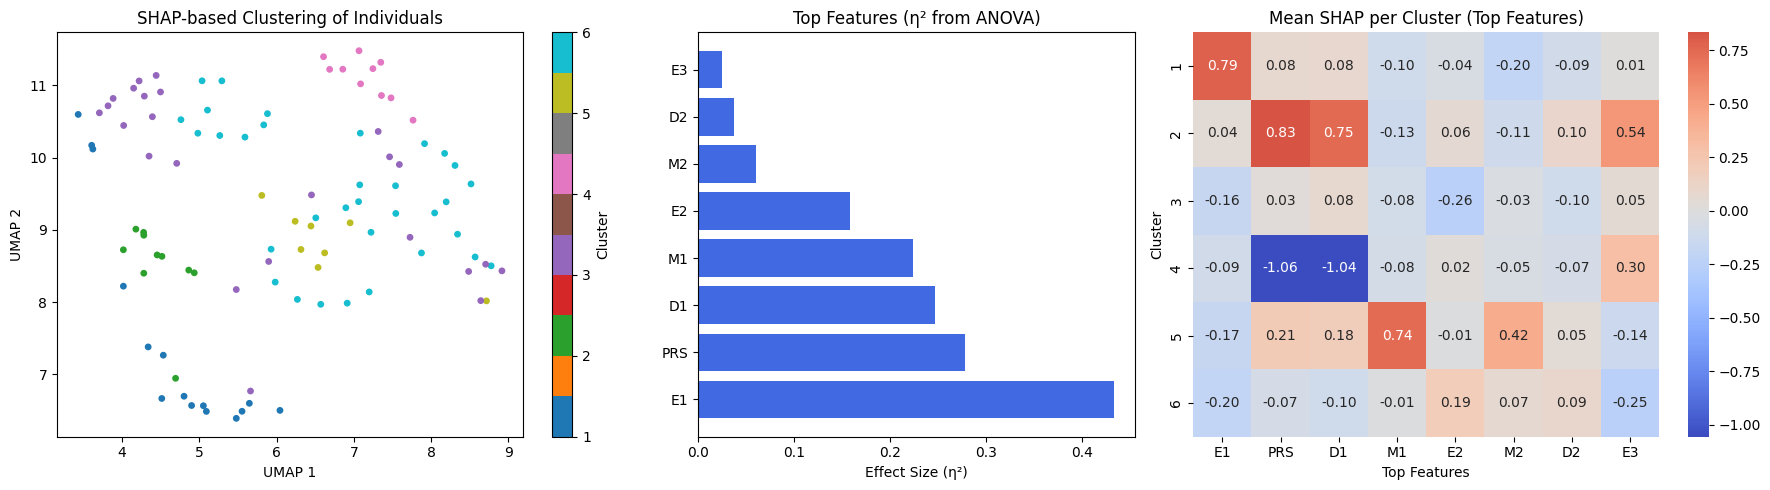

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
import seaborn as sns

# --- Assume you have already done ---
# - shap_matrix: (n_samples, n_features)
# - cluster_labels: array (n_samples,)
# - X_test.columns: feature names list

# If UMAP available
try:
    from umap import UMAP
    umap_model = UMAP(random_state=42)
    shap_umap = umap_model.fit_transform(shap_matrix)
except ImportError:
    print("UMAP not installed, falling back to PCA")
    pca = PCA(n_components=2)
    shap_umap = pca.fit_transform(shap_matrix)

# --- Step 1: ANOVA (feature selection based on η²) ---
F_values, p_values = f_classif(shap_matrix, cluster_labels)
eta_squared = F_values / (F_values + shap_matrix.shape[0] - shap_matrix.shape[1] - 1)

# Sort features by η² descending
feature_names = X_test.columns.tolist()
sorted_idx = np.argsort(-eta_squared)
top_features = np.array(feature_names)[sorted_idx][:10]
top_eta2 = eta_squared[sorted_idx][:10]

# --- Step 2: Mean SHAP per cluster (for heatmap) ---
cluster_df = pd.DataFrame(shap_matrix, columns=feature_names)
cluster_df['cluster'] = cluster_labels
mean_shap_by_cluster = cluster_df.groupby('cluster').mean()

# --- Step 3: Make Combined Figure ---

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1.5, 2]})

# --- Panel 1: UMAP scatter ---
sc = axs[0].scatter(shap_umap[:, 0], shap_umap[:, 1], c=cluster_labels, cmap='tab10', s=15)
axs[0].set_title('SHAP-based Clustering of Individuals')
axs[0].set_xlabel('UMAP 1')
axs[0].set_ylabel('UMAP 2')
cbar = fig.colorbar(sc, ax=axs[0])
cbar.set_label('Cluster')

# --- Panel 2: Barplot of Top η² Features ---
axs[1].barh(top_features[::-1], top_eta2[::-1], color='royalblue')
axs[1].set_title('Top Features (η² from ANOVA)')
axs[1].set_xlabel('Effect Size (η²)')
axs[1].invert_yaxis()  # Highest on top

# --- Panel 3: Heatmap of Mean SHAP Values ---
sns.heatmap(mean_shap_by_cluster[top_features], cmap='coolwarm', center=0,
            annot=True, fmt=".2f", ax=axs[2])
axs[2].set_title('Mean SHAP per Cluster (Top Features)')
axs[2].set_xlabel('Top Features')
axs[2].set_ylabel('Cluster')

plt.tight_layout()
plt.show()


In [22]:
### Simulating interventions
import copy

# --- Assume you have ---
# - X_test (your original input features, pandas DataFrame)
# - rf_model (or linreg_model)
# - cluster_labels

# Step 1: Choose which feature to intervene on
intervention_feature = 'E2'  # for example, one of your top features

# Step 2: Choose a new "healthier" value for the feature
# (Example: push M1 up to 1.5 if it’s important for improving outcomes)
new_value = 1

# Step 3: Make a copy of X_test for intervention
X_test_intervened = X_test.copy()

# Apply the intervention (set the feature to new_value)
X_test_intervened[intervention_feature] = new_value

# Step 4: Predict risk before and after intervention
# Predict with original data
y_pred_original = rf_model.predict(X_test)

# Predict with intervened data
y_pred_intervened = rf_model.predict(X_test_intervened)

# Step 5: Calculate risk reduction per sample
risk_reduction = y_pred_original - y_pred_intervened

# Step 6: Aggregate risk reduction by cluster
result_df = pd.DataFrame({
    'cluster': cluster_labels,
    'risk_reduction': risk_reduction
})

cluster_risk_reduction = result_df.groupby('cluster')['risk_reduction'].mean()

# Step 7: Plot
plt.figure(figsize=(8,5))
cluster_risk_reduction.plot(kind='bar', color='forestgreen')
plt.title(f'Average Risk Reduction per Cluster after {intervention_feature} Intervention')
plt.xlabel('Cluster')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='black', linestyle='--')
plt.show()


NameError: name 'rf_model' is not defined

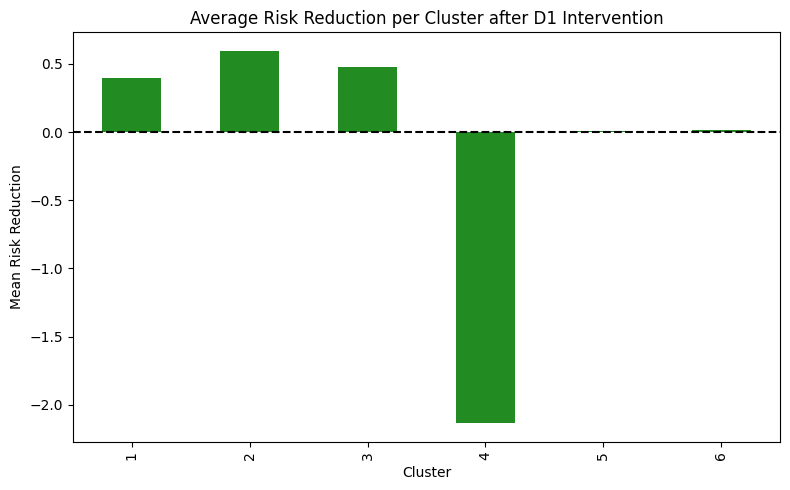

In [22]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Assumptions ---
# model: your loaded SimpleMLP model (on CPU or GPU)
# X_test: a pandas DataFrame (already scaled!)
# cluster_labels: 1D array-like of cluster assignments (same length as X_test)
# intervention_feature: string, one column in X_test
# new_value: float, the healthier target value

# Step 1: Choose the feature and value
intervention_feature = 'D1'
new_value = 1.6

# Step 2: Apply intervention
X_test_intervened = X_test.copy()
X_test_intervened[intervention_feature] = new_value

# Step 3: Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor_original = torch.tensor(X_test.values, dtype=torch.float32).to(device)
X_tensor_intervened = torch.tensor(X_test_intervened.values, dtype=torch.float32).to(device)

# Step 4: Predict using the model
model.eval()
with torch.no_grad():
    y_pred_original = model(X_tensor_original).cpu().numpy().flatten()
    y_pred_intervened = model(X_tensor_intervened).cpu().numpy().flatten()

# Step 5: Calculate risk reduction
risk_reduction = y_pred_original - y_pred_intervened

# Step 6: Aggregate by cluster
result_df = pd.DataFrame({
    'cluster': cluster_labels,
    'risk_reduction': risk_reduction
})
cluster_risk_reduction = result_df.groupby('cluster')['risk_reduction'].mean()

# Step 7: Plot
plt.figure(figsize=(8, 5))
cluster_risk_reduction.plot(kind='bar', color='forestgreen')
plt.title(f'Average Risk Reduction per Cluster after {intervention_feature} Intervention')
plt.xlabel('Cluster')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()


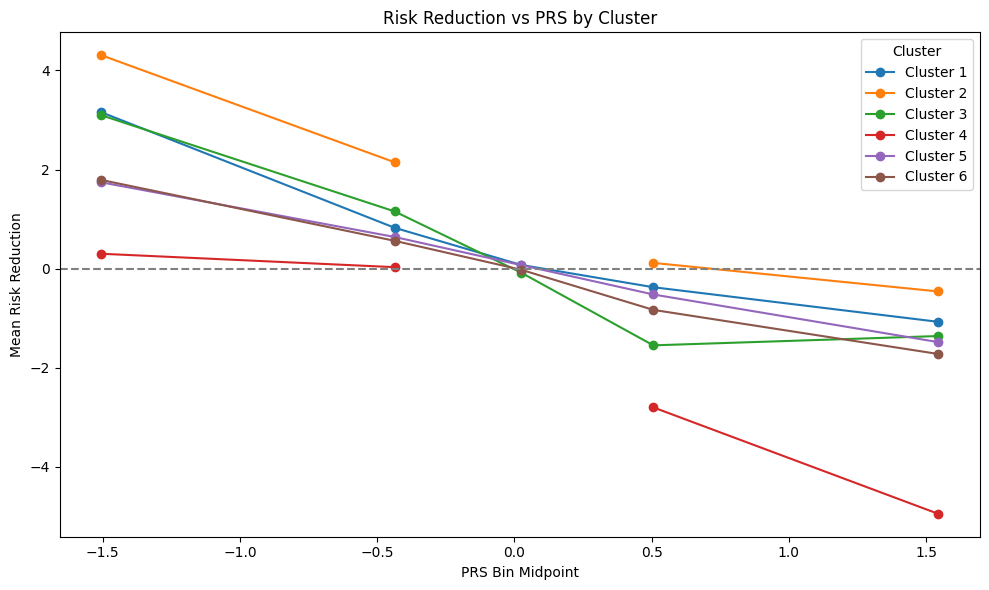

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Calculate risk reduction (from previous code)
risk_reduction = y_pred_original - y_pred_intervened

# Step 2: Create a results DataFrame
result_df = X_test.copy()
result_df['cluster'] = cluster_labels
result_df['risk_reduction'] = risk_reduction
result_df['PRS'] = X_test['PRS']  # replace with your actual PRS column name

# Step 3: Bin PRS into quantiles or fixed-width bins
num_bins = 5
result_df['PRS_bin'] = pd.qcut(result_df['PRS'], q=num_bins, duplicates='drop')

# Step 4: Group by PRS_bin and cluster, then take mean
grouped = result_df.groupby(['PRS_bin', 'cluster'])['risk_reduction'].mean().reset_index()

# Convert PRS_bin to string midpoint for plotting (or keep as categorical for clean tick labels)
grouped['PRS_mid'] = grouped['PRS_bin'].apply(lambda b: b.mid)

# Step 5: Pivot for plotting
plot_df = grouped.pivot(index='PRS_mid', columns='cluster', values='risk_reduction')

# Step 6: Plot each cluster as a line
plt.figure(figsize=(10, 6))
for cluster in plot_df.columns:
    plt.plot(plot_df.index, plot_df[cluster], label=f'Cluster {cluster}', marker='o')

plt.title('Risk Reduction vs PRS by Cluster')
plt.xlabel('PRS Bin Midpoint')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


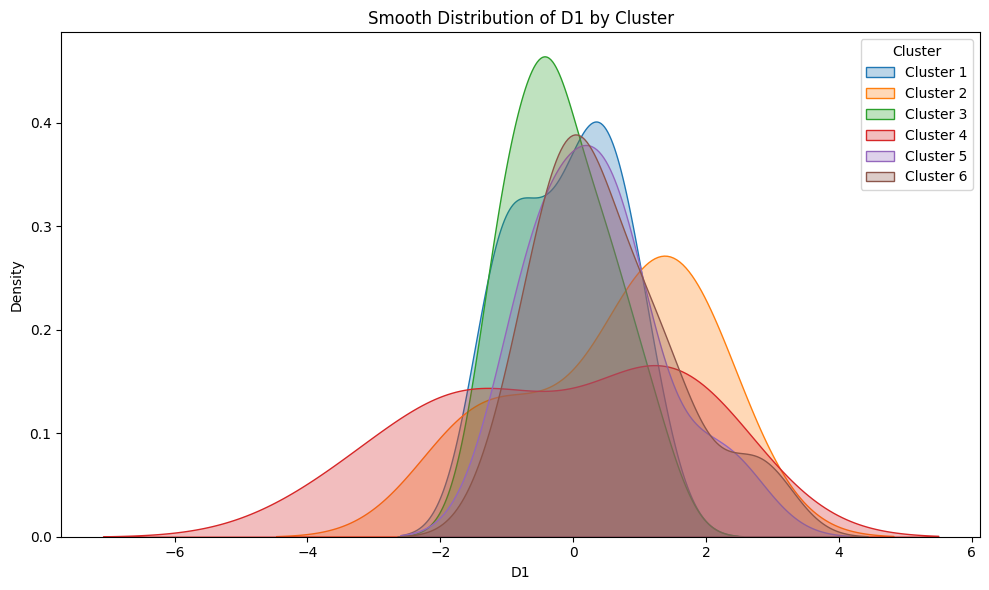

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Prepare DataFrame ---
plot_df = X_test.copy()
plot_df['cluster'] = cluster_labels
plot_df['D1'] = X_test['D1']  # ensure this is the correct column

# --- Plot KDE for each cluster ---
plt.figure(figsize=(10, 6))
for cluster in sorted(plot_df['cluster'].unique()):
    subset = plot_df[plot_df['cluster'] == cluster]
    sns.kdeplot(subset['D1'], label=f'Cluster {cluster}', fill=True, alpha=0.3)

plt.title('Smooth Distribution of D1 by Cluster')
plt.xlabel('D1')
plt.ylabel('Density')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


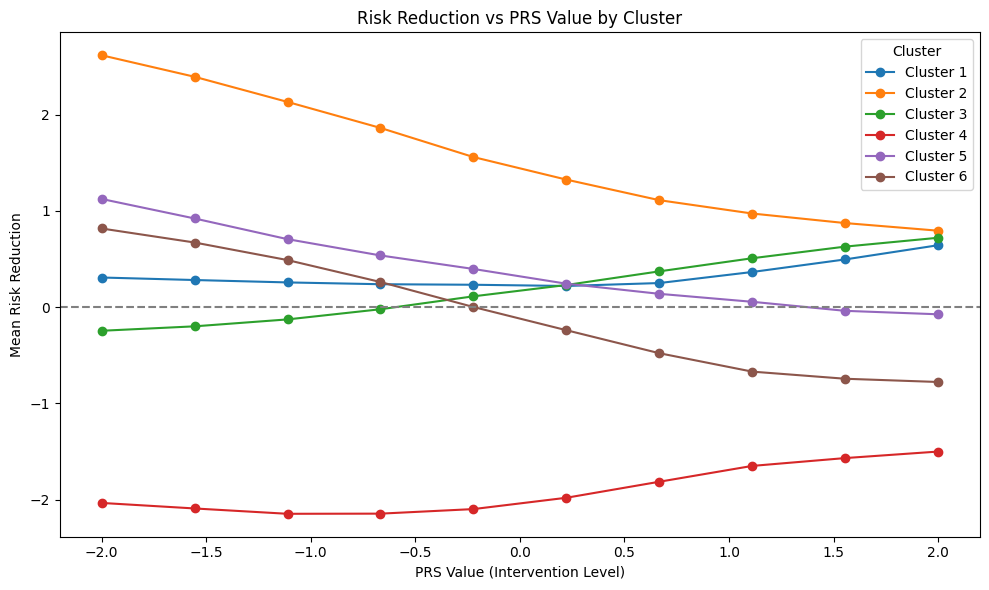

In [25]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Inputs ---
intervention_feature = 'PRS'
intervention_range = np.linspace(-2, 2.0, 10)  # range of D1 values to simulate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Container for results
results = []

# Loop through each intervention value
for val in intervention_range:
    # Apply intervention
    X_intervened = X_test.copy()
    X_intervened[intervention_feature] = val

    # Predict with original and intervened values
    X_tensor_original = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    X_tensor_intervened = torch.tensor(X_intervened.values, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_original = model(X_tensor_original).cpu().numpy().flatten()
        y_pred_intervened = model(X_tensor_intervened).cpu().numpy().flatten()

    # Compute risk reduction
    risk_reduction = y_pred_original - y_pred_intervened

    # Record results with cluster
    df = pd.DataFrame({
        'intervention_value': val,
        'cluster': cluster_labels,
        'risk_reduction': risk_reduction
    })

    results.append(df)

# Combine all
results_df = pd.concat(results)

# Group by intervention value + cluster
mean_reduction = results_df.groupby(['intervention_value', 'cluster'])['risk_reduction'].mean().reset_index()

# Pivot for plotting
plot_df = mean_reduction.pivot(index='intervention_value', columns='cluster', values='risk_reduction')

# --- Plot ---
plt.figure(figsize=(10, 6))
for cluster in plot_df.columns:
    plt.plot(plot_df.index, plot_df[cluster], label=f'Cluster {cluster}', marker='o')

plt.title(f'Risk Reduction vs {intervention_feature} Value by Cluster')
plt.xlabel(f'{intervention_feature} Value (Intervention Level)')
plt.ylabel('Mean Risk Reduction')
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()
